In [4]:
# Dance to import our kmeans model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from k_means import KMeans
from voronoi_processing import get_polygons, interpolate_centroid_history

In [5]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import seaborn_image as isns

# from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [74]:
video_path = "../local_files/k_means/bees_original.mp4"  # too large to have on GitHub

In [3]:
# First read the video into memory
reader = cv2.VideoCapture(video_path)

frames = []
while True:
    print(f"Reading frame: {len(frames)}", end="\r")
    ret, frame = reader.read(cv2.IMREAD_GRAYSCALE)
    if ret:
        grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(grayscale)
    else:
        break

frames = np.array(frames)

In [7]:
# For the sake of PCA speed, we're going to downsample the frames by 4.
new_shape = np.array(frames.shape)
new_shape[1:] = new_shape[1:] // 4
frames_downsized = np.zeros(new_shape, dtype=np.uint8)

for i in range(frames.shape[0]):
    print(f"Resizing frame: {i+1}/{frames.shape[0]}", end="\r")
    frames_downsized[i] = cv2.resize(frames[i], frames_downsized.shape[1:]).T


In [8]:
# Then decompose the frames into 2 components
# to do this, first reshape the frames
print("Flattening...")
frames_downsized_flattened = frames_downsized.reshape(frames.shape[0], -1)

print("Decomposing...")
pca = PCA(n_components=2)
frames_2dim = pca.fit_transform(frames_downsized_flattened)  # then fit transform the frames

Flattening...
Decomposing...


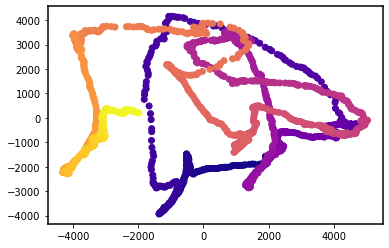

In [62]:
# Visualize the decomposed frames. The colors progress with time
colors = plt.get_cmap("plasma")(np.linspace(0, 1, frames_2dim.shape[0]))
plt.scatter(frames_2dim[:, :1], frames_2dim[:, 1:], c=colors)

In [55]:
# Now we can cluster the video to identify unique frames 
clusters = 8
kmeans = KMeans(n_clusters=8)
kmeans.fit(frames_2dim)
labels = kmeans.labels
centroid_positions = kmeans.cluster_centers

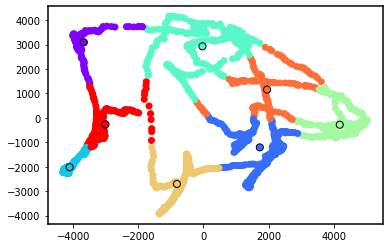

In [56]:
# Visualize the frame clusters
colors = plt.get_cmap("rainbow")(np.linspace(0, 1, clusters))
data_colors = colors[labels]

plt.scatter(frames_2dim[:, :1], frames_2dim[:, 1:], c=data_colors)
plt.scatter(
    centroid_positions[:, 0],
    centroid_positions[:, 1],
    s=50,
    c=colors, 
    edgecolors="black"
)

In [59]:
# Now we can select our ten frames from the clusters.
def find_closest_index(input_data, centroid):
    """Return the value in the input_data that is closet to the centroid position."""
    diff = np.abs(input_data - centroid).sum(axis=1)

    closest_index = np.argmin(diff)
    
    return closest_index

label_frame_indices = []
for i in range(clusters):
    input_data = frames_2dim[labels==i]
    input_indices = np.argwhere(labels==i)
    relative_index = find_closest_index(input_data, centroid_positions[i])
    abs_index = input_indices[relative_index]
    label_frame_indices.append(abs_index[0])


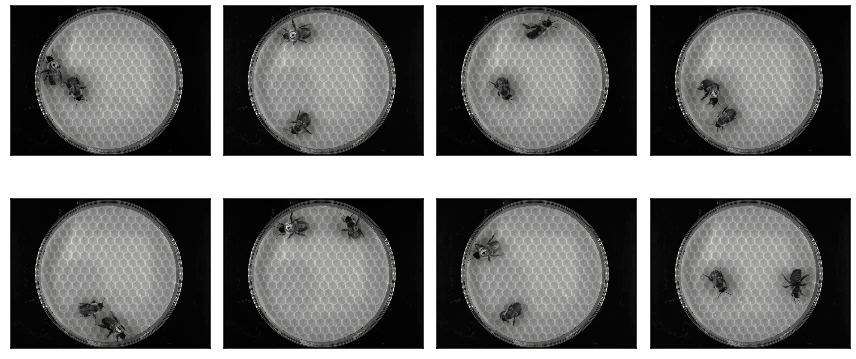

In [63]:
# Visualize the selected frames
selected_frames = frames[label_frame_indices]

g = isns.ImageGrid([*selected_frames], col_wrap=4, cbar=False, cmap="gray")

In [71]:
centroid_history = kmeans.centroid_history
centroid_history = np.array(centroid_history)
centroid_history.shape

(9, 8, 2)